# Imports

In [69]:
import os
import copy
import math
import csv
import numpy as np
import pandas as pd
from itertools import product
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

np.random.seed(0)
np.seterr(divide = 'ignore') 
plt.style.use('seaborn-paper')

# Dataset

## Loading dataset

In [70]:
!gdown 11qXv2vipvTPVVKyB2x_otsl1s3sSvonk
!unzip -o data.zip -d data

Downloading...
From: https://drive.google.com/uc?id=11qXv2vipvTPVVKyB2x_otsl1s3sSvonk
To: /content/data.zip
100% 18.5k/18.5k [00:00<00:00, 25.2MB/s]
Archive:  data.zip
  inflating: data/Contextual_data.xlsx  
  inflating: data/samples/sample_1.csv  
  inflating: data/samples/sample_11.csv  
  inflating: data/samples/sample_12.csv  
  inflating: data/samples/sample_13.csv  
  inflating: data/samples/sample_14.csv  
  inflating: data/samples/sample_15.csv  
  inflating: data/samples/sample_16.csv  
  inflating: data/samples/sample_18.csv  
  inflating: data/samples/sample_19.csv  
  inflating: data/samples/sample_2.csv  
  inflating: data/samples/sample_20.csv  
  inflating: data/samples/sample_21.csv  
  inflating: data/samples/sample_23.csv  
  inflating: data/samples/sample_24.csv  
  inflating: data/samples/sample_25.csv  
  inflating: data/samples/sample_3.csv  
  inflating: data/samples/sample_4.csv  
  inflating: data/samples/sample_5.csv  
  inflating: data/samples/sample_6.csv  

In [71]:
excel_data = pd.read_excel('data/Contextual_data.xlsx',engine='openpyxl')

Y = list()
for _id in excel_data['sample no.']:
    sample_path = 'data/samples/sample_{}.csv'.format(_id)
    if os.path.exists(sample_path):
        Y.append(pd.read_csv(sample_path))

In [72]:
Y_train, Y_test = train_test_split(Y, test_size=1, random_state=42)

# Utils

In [73]:
def log(x):
    if x < 0:
        raise ValueError('Negative value encoutered', x)
    elif x == 0:
        return -np.inf
    else:
        return np.log(x)

In [74]:
def exp(x):
    if x == -np.inf:
        return 0
    elif x == np.inf:
        raise ValueError('Positive infinity in epx')
    else:
        return np.exp(x)

In [75]:
def log_sum(ln_x, ln_y):
    # implementation based on Algorithm 3 of link http://bozeman.genome.washington.edu/compbio/mbt599_2006/hmm_scaling_revised.pdf
    if ln_x == -np.inf or ln_y == -np.inf:
        # Note: if both ln_x and ln_y were -inf we inevitably return -inf
        if ln_x == -np.inf:
            return ln_y
        else:
            return ln_x 
    else:
        if ln_x > ln_y:
            return ln_x + log(1 + exp(ln_y - ln_x))
        else:
            return ln_y + log(1 + exp(ln_x - ln_y))

In [76]:
def log_product(ln_x, ln_y):
    # implementation based on Algorithm 4 of link http://bozeman.genome.washington.edu/compbio/mbt599_2006/hmm_scaling_revised.pdf
    if ln_x == -np.inf or ln_y == -np.inf:
        return -np.inf
    else:
        return ln_x + ln_y

## Checking sample lengths

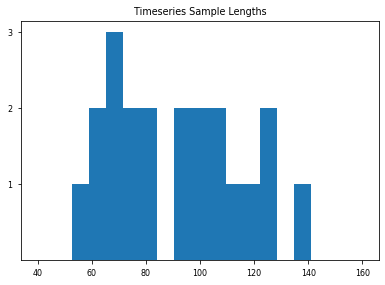

In [77]:
lengths = []
for y in Y:
    lengths.append(len(y))

plt.hist(lengths, np.linspace(40, 160, 20))
plt.yticks([1,2,3])
plt.title('Timeseries Sample Lengths')
plt.show()

## Cleaning data

In [78]:
def clean_batch(batch):

    def _clean_sample(sample):
        out = sample.copy()

        out.drop('Unnamed: 0', axis=1, inplace=True)

        for col in out.columns:
            out[col].fillna(out[col].mode()[0], inplace=True)
        
        out = out[['f1', 'f2', 'f3', 'f4', 'f5', 'target']]
        out = out[(out.target==1)|(out.target==2)]
        out.reset_index(drop=True, inplace=True)

        out.target -= 1 # so can be used as index

        return out

    cleaned_batch = list()
    for sample in batch:
        cleaned_batch.append(_clean_sample(sample))
    return cleaned_batch

# Constants

In [79]:
STATE = [0, 1]
FEATURE = [0, 1, 2, 3, 4]
NUMBER_STATE = 2
TIME_SERIES_LENGTH = 160
SMALL_VALUE = 1e-9

# Hidden Markov Models

## Sum-product

### $\alpha$, $\beta$ recursions

Implement the $\alpha$ and $\beta$-recursions.

Recall that $\alpha(x_t) := p(x_t, y_{1:t})$, $\beta(x_t) := p(y_{(t+1):T} | x_t)$. Implement also a function to compute the emission probabilties $\epsilon_k(y_t) := p(y_t|x_t=k)$.

For numerical stability reasons, you can implement your algorithms using **log probabilities**!



In [80]:
def comp_transition(Y):
    # Note: Y is BATCH of time series samples

    # initialization
    M = np.zeros((NUMBER_STATE, NUMBER_STATE))

    # frequency count
    for y in Y:
        pst = y.target[0]
        for st in y.target[1:]:
            M[pst-1, st-1] += 1
            pst = st
    
    # normalization
    for st in STATE:
        total_freq = sum(cnt for cnt in M[st]) + 1e-9 # add with small number to avoid Division by zero
        M[st] = np.array([cnt/total_freq for cnt in M[st]])
    
    return M

def emission_prob(eps, state, obs):
    prob = 1
    for fi in FEATURE:
        prob *= eps[state][fi].get(obs[fi], 0) + 1e-9 # Add very little prob for numerically stable reason.
    return prob

def emission(Y):
    # Note: Y is a BATCH of time series samples

    # initialization
    eps = {st: dict() for st in STATE}
    for fi in FEATURE:
        for st in STATE:
            eps[st][fi] = dict()

    # frequency count
    for sample in Y:
        for t, ins in sample.iterrows():
            *obs, state = ins
            for fi in FEATURE:
                if obs[fi] not in eps[state][fi]:
                    eps[state][fi][obs[fi]] = 0
                eps[state][fi][obs[fi]] += 1
    
    # normalization
    for st in STATE:
        for fi in eps[st]:
            total_freq_fi = sum(eps[st][fi][fv] for fv in eps[st][fi])
            eps[st][fi] = {fv: eps[st][fi][fv]/total_freq_fi for fv in eps[st][fi]}

    return eps

def alpha_recursion(Y, M, eps, pi):
    # Note: Y is SINGLE time series sample
    # implemented based on Algorithm 5
    # Solution for numerical issues are based on https://courses.engr.illinois.edu/ece417/fa2020/slides/lec14.pdf

    # initialization step
    log_alpha = np.zeros((TIME_SERIES_LENGTH, NUMBER_STATE))
    for st in STATE:
        *obs, _ = Y.iloc[0]
        log_alpha[0, st] = log_product(log(pi[st]), log(emission_prob(eps, st, obs)))

    # recursion step
    for t, vars in Y.iloc[1:].iterrows():
        *obs, _ = vars
        for stj in STATE:
            log_a = -np.inf
            for sti in STATE:
                log_a = log_sum(log_a, log_product(log_alpha[t-1, sti], log(M[sti][stj])))
            log_alpha[t, stj] = log_product(log_a, log(emission_prob(eps, stj, obs)))

    return log_alpha

def beta_recursion(Y, M, eps) :
    # Note: Y is SINGLE time series sample
    # Implementation is based on Algorithm 6

    # initialization step
    T = len(Y)
    log_beta = np.zeros((TIME_SERIES_LENGTH, NUMBER_STATE))
    for st in STATE:
        log_beta[T-1, st] = 0

    # recursion step
    for t in reversed(range(T-1)):
        *nobs, _ = Y.iloc[t+1]
        for sti in STATE:
            log_b = -np.inf
            for stj in STATE:
                log_b = log_sum(log_b, 
                                log_product(log(M[sti][stj]),
                                            log_product(emission_prob(eps, stj, nobs),
                                                        log_beta[t+1, stj])
                                            )
                                )
            log_beta[t, sti] = log_b
    return log_beta

Using the two functions above, implement the computation of the *smoothing* distribution $p(x_t|y_1,\dots,y_T)$ and pair-marginals $p(x_t,x_{t+1}|y_1,\dots,y_T)$. Here use log probabilities from the $\alpha$ and $\beta$, but return a normal (not log!) probability, i.e, a number in $[0,1]$.

In [81]:
def smoothing(log_alpha, log_beta):
    T, K = alpha.shape

    log_gamma = np.zeros((T, K))
    for t in range(T):
        normalizer = -np.inf
        for st in STATE:
            log_gamma[t, st] = log_product(log_alpha[t,st], log_beta[t,st])
            normalizer = log_sum(normalizer, log_gamma[t, st])

        for st in STATE:
            log_gamma[t, st] = log_product(log_gamma[t,st], -normalizer)

    return log_gamma

def pair_marginals(Y, log_alpha, log_beta, M, eps):
    T, K = alpha.shape

    log_psi = np.zeros((T, K, K))
    for t in range(len(Y) - 1):
        *nobs, _ = Y.iloc[t+1]
        normalizer = -np.inf
        for sti in STATE:
            for stj in STATE:
                log_psi[t, sti, stj] = log_product(log_alpha[t, sti], 
                                                   log_product(log(M[sti, stj]),
                                                               log_product(log(emission_prob(eps, stj, nobs)),
                                                                           log_beta[t+1, stj]
                                                                           )
                                                               )
                                                   )
                normalizer = log_sum(normalizer, log_psi[t, sti, stj])

        for sti in STATE:
            for stj in STATE:
                log_psi[t, sti, stj] = log_product(log_psi[t, sti, stj], -normalizer)

    return log_psi

Let $\{y_1,\dots,y_T\}$ be the **test** data. Using your functions above, for all $t$ on the test data, compute $\alpha_t$, $\beta_t$ and  $p(x_t | y_1,\dots,y_T)$. Finally, plot $p(x_t|y_1,\dots,y_T)$ for each of the 2 states as a function of $t$ for one sample. 

In [82]:
def plot_smoothing(gamma, y, K=2, time_limit=160):
    plt.figure(figsize=(16, 3*K))
    plt.suptitle('Smoothing probabilities $p(z_t|x_1, ..., x_T)$', fontsize=16)
    for k in range(K):
        plt.subplot(3, 1, 1+k)
        plt.plot(range(1, time_limit+1), np.exp(gamma[:time_limit, k]))
        plt.ylabel(r'$p(z_t = ' + str(k+1) + ' | x_{1:T})$')
        plt.ylim(-0.1, 1.1)
        plt.grid(True)
    plt.subplot(3, 1, 3)
    plt.plot(range(1, time_limit+1), y.target.tolist())
    plt.ylabel(r'Expected')
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    plt.xlabel('t')
    plt.show()

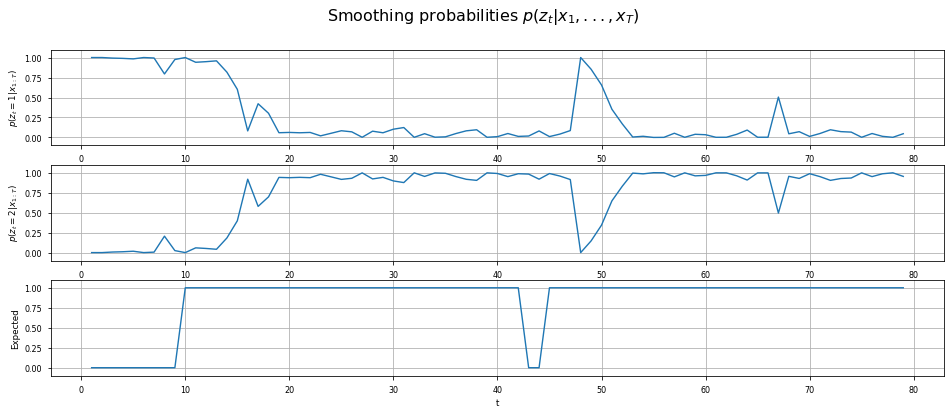

In [83]:
# ---------------------------------------------------------------------------- #
#     Do NOT change the contents of this cell. This is just for execution.     #
#   If you respected function signatures, this cell should run without changes #
# ---------------------------------------------------------------------------- #

# Compute emission (log) probabilities
Yc_train, Yc_test = clean_batch(Y_train), clean_batch(Y_test)
eps = emission(Yc_train)
M = comp_transition(Yc_train)
pi = np.array([1, 1e-9])

# Perform (log) alpha and beta recursions
alpha = alpha_recursion(Yc_test[0], M, eps, pi)
beta = beta_recursion(Yc_test[0], M, eps)

# Compute smoothing probabilities
gamma = smoothing(alpha, beta)

# Now we do the plot of the smoothing probability for each of the 4 states
plot_smoothing(gamma, Yc_test[0], time_limit=Yc_test[0].shape[0])

## Expectation-Maximization (EM)

Implement the EM algorithm to learn the parameters of the model ($\pi,M,\: k=1,2$). 

In [84]:
def exp_max(Y_train, Y_test, init_params):

    def is_converged(pbar, prev_A, A, prev_B, B, prev_Pi, Pi):
        B_diff = 0
        for st in STATE:
            for fi in FEATURE:
                for fvi in feature_value[fi]:
                    B_diff += np.abs(B[st][fi].get(fvi, 1e-9) - prev_B[st][fi].get(fvi, 1e-9))
        
        Pi_diff = np.sum(abs(prev_Pi - Pi))
        A_diff = np.sum(np.sum(abs(prev_A - A)))

        pbar.update()
        pbar.set_description('B_diff = {:.3E}, A_diff = {:.3E}, pi_diff={:.3E}'.format(B_diff, A_diff, Pi_diff))
        return B_diff < 1e-3 and A_diff < 1e-3 and Pi_diff < 1e-3
    
    def get_feature_values(Y_train):
        feature_value = {fi: list() for fi in FEATURE}
        for y in Y_train:
            for fi in FEATURE:
                feature_value[fi] = list(set(feature_value[fi]).union(set(y.iloc[:,fi])))
        return feature_value

    def create_B_matrix():
        B = {st: dict() for st in STATE}
        for fi in FEATURE:
            for st in STATE:
                B[st][fi] = dict()
                for fvi in feature_value[fi]:
                    B[st][fi][fvi] = 0
        return B

    def e_step(y, M, eps, pi):
            log_alpha = alpha_recursion(y, M, eps, pi)
            log_beta = beta_recursion(y, M, eps)
            log_gamma = smoothing(log_alpha, log_beta)
            log_psi = pair_marginals(y, log_alpha, log_beta, M, eps)
            return log_gamma, log_psi

    def never_ending_generator():
        while True:
            yield

    # Set initialization from parameters given in previous question
    (pi, M, eps) = init_params
    feature_value = get_feature_values(Y_train)

    train_avg_llike  = []
    test_avg_llike  = []

    # Would re-initialize inside while
    prev_A, A = np.zeros(M.shape), M
    prev_B, B = create_B_matrix(), eps
    prev_pi, pi = np.zeros(pi.shape), pi

    with tqdm(never_ending_generator()) as pbar:
        while not is_converged(pbar, prev_A, A, prev_B, B, prev_pi, pi):

            log_likelihood_train = 0
            for y in Y_train:
                log_alpha = alpha_recursion(y, A, B, pi)
                sample_llikelihood = -np.inf
                for st in STATE:
                    sample_llikelihood = log_sum(sample_llikelihood, log_alpha[len(y)-1, st])
                log_likelihood_train = log_product(log_likelihood_train, sample_llikelihood)
            train_avg_llike.append(log_likelihood_train)
            
            log_likelihood_test = 0
            for y in Y_test:
                log_alpha = alpha_recursion(y, A, B, pi)
                sample_llikelihood = -np.inf
                for st in STATE:
                    sample_llikelihood = log_sum(sample_llikelihood, log_alpha[len(y)-1, st])
                log_likelihood_test = log_product(log_likelihood_test, sample_llikelihood)
            test_avg_llike.append(log_likelihood_test)

            # Initializing the variables
            prev_A, A = copy.deepcopy(A), np.zeros(A.shape)
            prev_B, B = copy.deepcopy(B), create_B_matrix()
            prev_pi, pi = copy.deepcopy(pi), pi

            log_gamma, log_psi = list(), list()
            for y in Y_train:
                log_g, log_s = e_step(y, prev_A, prev_B, prev_pi)
                log_gamma.append(log_g)
                log_psi.append(log_s)

            # Computing pi
            for st in STATE:
                numerator = -np.inf
                for yi, y in enumerate(Y_train):
                    numerator = log_sum(numerator, log_gamma[yi][0, st])
                pi[st] = exp(log_product(numerator, -log(len(Y_train))))

            # Computing A
            for sti in STATE:
                for stj in STATE:
                    numerator, denominator = -np.inf, -np.inf
                    for yi, y in enumerate(Y_train):
                        for t in range(len(y)-1):
                            numerator = log_sum(numerator, log_psi[yi][t, sti, stj])
                            denominator = log_sum(denominator, log_gamma[yi][t, sti])
                    A[sti, stj] = exp(log_product(numerator, -denominator))

            # Computing B
            for fi in FEATURE:
                for fv in feature_value[fi]:
                    for st in STATE:
                        numerator, denominator = -np.inf, -np.inf
                        for yi, y in enumerate(Y_train):
                            for t in range(len(y)):
                                if y.iloc[t, fi] == fv:
                                    numerator = log_sum(numerator, log_gamma[yi][t, st])
                                denominator = log_sum(denominator, log_gamma[yi][t, st])
                        B[st][fi][fv] = exp(log_product(numerator, -denominator))

    return A, B, pi, train_avg_llike, test_avg_llike

Learn the parameters of the HMM using the **training** data and plot the average log-likelihood on the train and test data as a function of the iterations of the algorithm. Comment on your observations.

0it [00:00, ?it/s]

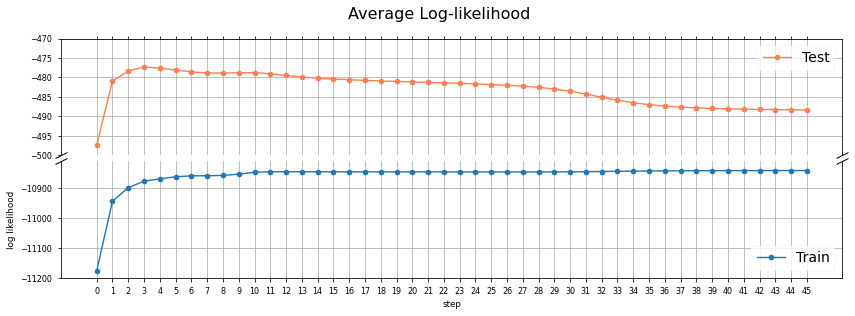

In [85]:
# Estimate parameters using EM and collect results
Yc_train, Yc_test = clean_batch(Y_train), clean_batch(Y_test)
pi = np.array([1, 1e-9])
M = comp_transition(Yc_train)
eps = emission(Yc_train)
INIT_PARAMS = (pi, M, eps)
res = exp_max(Yc_train, Yc_test, INIT_PARAMS)
M_em, eps_em, pi_em, train_avg_llike, test_avg_llike = res

# Plot the log-likelihoods
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.set_figwidth(14)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

ax1.plot(test_avg_llike, marker='o', color='coral', label='Test')
ax2.plot(train_avg_llike, marker='o', label='Train')

ax1.set_ylim(-500, -470)
ax2.set_ylim(-11200, -10810)

# hide the spines between ax and ax2
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

plt.xticks(list(range(len(train_avg_llike))))
ax1.legend(fontsize=14)
ax2.legend(fontsize=14)

ax1.grid(True)
ax2.grid(True)

plt.suptitle('Average Log-likelihood', fontsize=16)
plt.ylabel('log likelihood')
plt.xlabel('step')
plt.show()

## Viterbi 

Implement Viterbi decoding.

In [90]:
def viterbi(Y, pi, M, eps):
    # initialization step
    vit = np.zeros((NUMBER_STATE, TIME_SERIES_LENGTH))
    backpointer = np.zeros((NUMBER_STATE, TIME_SERIES_LENGTH))
    for st in STATE:
        *obs, _ = Y.iloc[0]
        vit[st, 0] = log_product(log(pi[st]), log(emission_prob(eps, st, obs)))
        backpointer[st, 0] = None

    # recursion step
    for t, vars in Y.iloc[1:].iterrows():
        *obs, _ = vars
        for st in STATE:
            _c = [log_product(vit[pst, t-1], 
                              log_product(log(M[pst][st]), 
                                          log(emission_prob(eps, st, obs)))) for pst in STATE]
            vit[st, t] = max(_c)
            backpointer[st, t] = np.argmax(_c)
    
    # termination step
    best_path_prob = max(vit[:, t])
    best_state_ptr = np.argmax(vit[:, t])

    best_path = []
    while not math.isnan(best_state_ptr):
        best_state_ptr = int(best_state_ptr)
        best_path.append(best_state_ptr)
        best_state_ptr = backpointer[best_state_ptr, t]
        t -= 1
    best_path.reverse()

    return best_path, best_path_prob

Using the set of parameters learned with the EM algorithm on the **training** set, compute the most likely sequence of states for the **training** data with the Viterbi algorithm. Plot your results.

In [91]:
def plot_viterbi(predicted_path, expected_path):
    plt.figure(figsize=(28, 4))
    plt.suptitle('Predict Hidden State via Viterbi', fontsize=16)
    for i, ins in enumerate({'predicted': predicted_path, 'expected': expected_path}.items()):
        plt.subplot(2, 1, 1+i)
        plt.plot(ins[1], marker='o')
        plt.xticks(list(range(len(ins[1]))))
        plt.yticks(STATE)
        plt.ylim(-0.1, 1.1)
        plt.ylabel(ins[0])
        plt.grid(True)
    plt.xlabel('t')
    plt.show()

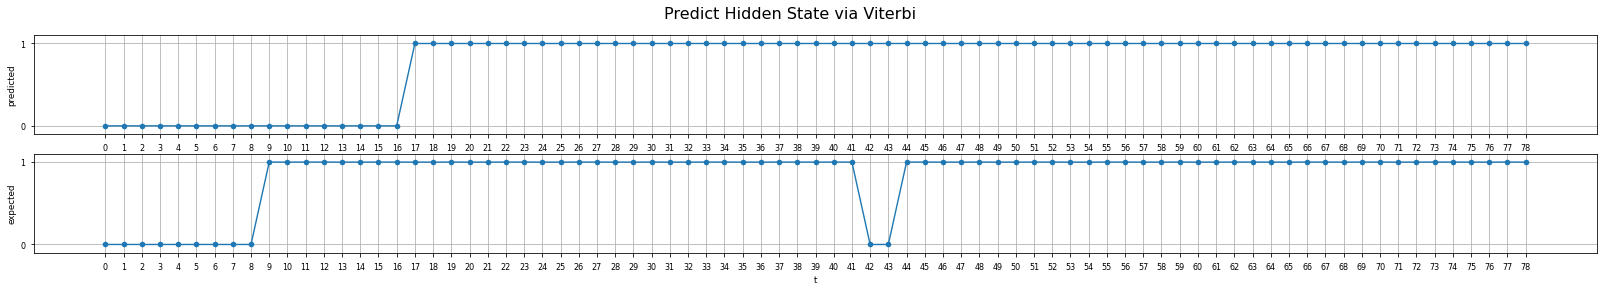

In [92]:
# Get one_hot_labels from Viterbi and turn them into 0, ..., K-1 "numeric" labels
Yc_test = clean_batch(Y_test)
best_path, best_path_prob = viterbi(Yc_test[0], pi, M, eps)

plot_viterbi(predicted_path=best_path, expected_path=Yc_test[0].target.tolist())

# Training

In [93]:
from itertools import combinations

pi = np.array([1, 1e-9])
Yc = clean_batch(Y)

for length in range(1, 6):
    FEATUREs = combinations([0, 1, 2, 3, 4], length)
    for FEATURE in FEATUREs:
        overal_acc = 0
        for i in tqdm(range(len(Yc))):
            yc_test = Yc[i]
            Yc_train = [Yc[j] for j in range(len(Yc)) if j!=i]

            eps = emission(Yc_train)
            M = comp_transition(Yc_train)

            best_path, _ = viterbi(yc_test, pi, M, eps)
            overal_acc += accuracy_score(y_true=yc_test.target.tolist(), y_pred=best_path) / len(Yc)
        print("Overal Accuracy: {} with features {}".format(overal_acc, FEATURE))

  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.758719189305957 with features (0,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.3890556432080186 with features (1,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5951356382187238 with features (2,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6663365274985117 with features (3,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.481864856949889 with features (4,)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.776045242534266 with features (0, 1)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7668586998657612 with features (0, 2)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7621523170456256 with features (0, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7618837926575059 with features (0, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6186810083492174 with features (1, 2)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6328857134818863 with features (1, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.5178527303601227 with features (1, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6249621059383442 with features (2, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6954843065424833 with features (2, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6714104744024265 with features (3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7870047541548462 with features (0, 1, 2)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7859053093644763 with features (0, 1, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7921090711747099 with features (0, 1, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7726829072770536 with features (0, 2, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7787247097446691 with features (0, 2, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7802448507095336 with features (0, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6585780738800633 with features (1, 2, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6987089435538382 with features (1, 2, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6877856311751069 with features (1, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.6829986354130786 with features (2, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.776896466178592 with features (0, 1, 2, 3)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.8024685067803915 with features (0, 1, 2, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7941344859389189 with features (0, 1, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7828357790895834 with features (0, 2, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7046998421526542 with features (1, 2, 3, 4)


  0%|          | 0/21 [00:00<?, ?it/s]

Overal Accuracy: 0.7975043658844659 with features (0, 1, 2, 3, 4)


# Test

Initializing constants with best results

In [94]:
FEATURE = [0, 1, 2, 4]

Cleaning train samples

In [95]:
Y_train_idx = list(range(len(Y)))
Y_train = Y

Yc_train = clean_batch(Y_train)

Calculate $\epsilon$ and transition matrix.

In [96]:
eps = emission(Yc_train)
M = comp_transition(Yc_train)

Reading test samples.

In [97]:
excel_data = pd.read_excel('Contextual_data.xlsx', engine='openpyxl')

Y_test = list()
Y_test_idx = list()
for _id in excel_data['sample no.']:
    sample_path = 'test_{}.csv'.format(_id)
    if os.path.exists(sample_path):
        Y_test.append(pd.read_csv(sample_path))
        Y_test_idx.append(_id)

FileNotFoundError: ignored

Writing output

In [98]:
Yc_test = clean_batch(Y_test)

for idx, yc_test in zip(Y_test_idx, Yc_test):
    best_path, _ = viterbi(yc_test, pi, M, eps)

    with open('output_{}.csv'.format(idx), 'w') as f:
        write = csv.writer(f)
        write.writerow(best_path)

NameError: ignored